# Orphia - Notebook
Melody Generation using an RNN-LSTM Model with Keras/TensorFlow.

### Setup: Import Libraries and Define Configuration

In [1]:
import os
import json
import random
import numpy as np
import warnings

In [2]:
import music21 as m21
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

In [4]:
warnings.filterwarnings("ignore", category=UserWarning, module='music21')
warnings.filterwarnings("ignore", category=FutureWarning)
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore', message=".*Error in parsing event.*Incorrect meter.* found.*")

In [5]:
DATASET_PATH = "dataset\europa\deutschl"

<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
C:\Users\arv95\AppData\Local\Temp\ipykernel_11072\2132368959.py:1: SyntaxWarning: invalid escape sequence '\e'
  DATASET_PATH = "dataset\europa\deutschl"


In [6]:
NUM_FILES_TO_USE = 1800
PARSE_ERRORS_LOG = "parse_errors.log"

In [7]:
SEQUENCE_LENGTH = 64
STEP = 1

_-- Model Architecture & Training --_

In [8]:
UNITS = 256
LOSS_FUNCTION = "categorical_crossentropy"
OPTIMIZER = "adam"
BATCH_SIZE = 128
EPOCHS = 200
VALIDATION_SPLIT = 0.15
EARLY_STOPPING_PATIENCE = 10

_-- Music Generation --_

In [9]:
GENERATION_SEED_LENGTH = SEQUENCE_LENGTH
# > 1.0: More random, exploratory, potentially chaotic.
# = 1.0: Uses the model's learned probabilities directly.
# < 1.0: More conservative, deterministic, potentially repetitive.
TEMPERATURE = 1.0
# How many musical symbols (notes/chords/rests) to generate after the seed.
MELODY_DURATION_SYMBOLS = 200

_-- Output Files & Directories --_

In [10]:
SAVE_DIR = "results"
MAPPING_PATH = os.path.join(SAVE_DIR, "symbol_mappings.json")
MODEL_CHECKPOINT_PATH = os.path.join(SAVE_DIR, "model-weights-{epoch:02d}-{val_loss:.4f}.keras")
FINAL_MODEL_PATH = os.path.join(SAVE_DIR, "final_melody_generator_model.keras")
LOG_DIR = os.path.join(SAVE_DIR, "logs")
GENERATED_MIDI_PATH = os.path.join(SAVE_DIR, "generated_melody.mid")

_Making sure Output Directories exist_

In [11]:
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

_-- Test Files (for visualization) --_

In [12]:
TEST_AUDIO_DIR = "test"
TEST_FILE_1 = os.path.join(TEST_AUDIO_DIR, "sample1.mid")
TEST_FILE_2 = os.path.join(TEST_AUDIO_DIR, "sample.mid")
os.makedirs(TEST_AUDIO_DIR, exist_ok=True)

In [13]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


### Data Loading and Preprocessing ##

This section defines the function to load and process the symbolic music data from `.krn` files into a unified list of musical symbols.

In [14]:
def load_and_preprocess_songs(dataset_path, num_files_to_use, error_log_file):
    """
    Loads Kern files, parses them using music21, and extracts musical symbols.

    Args:
        dataset_path (str): Path to the directory containing .krn files (recursive search).
        num_files_to_use (int): Maximum number of files to process.
        error_log_file (str): Path to log files that failed parsing.

    Returns:
        list: A single list containing all extracted musical symbols from the processed files.
            Symbols are strings representing "pitch(es)|duration" or "R|duration".
            Example: "60|1.0", "60_64_67|0.5", "R|2.0"
    """
    all_symbols = []
    processed_files = 0
    file_count = 0
    parse_errors = 0

    print(f"Searching for .krn files in: {dataset_path}")
    if not os.path.exists(dataset_path):
        print(f"ERROR: Dataset path not found: {dataset_path}")
        return []

    # Clear error log file
    if os.path.exists(error_log_file):
        os.remove(error_log_file)

    for root, _, files in os.walk(dataset_path):
        if processed_files >= num_files_to_use:
            break
        for file in files:
            if file.endswith(".krn"):
                file_count += 1
                file_path = os.path.join(root, file)

                if processed_files >= num_files_to_use:
                    break

                print(f"\rProcessing file {processed_files + 1}/{num_files_to_use}: {file_path}...", end="")

                try:
                    score = m21.converter.parse(file_path)
                    elements_to_parse = None
                    try:
                        # Attempt to get parts, assuming instrument/voice parts
                        parts = m21.instrument.partitionByInstrument(score)
                        if parts:
                            elements_to_parse = parts.parts[0].recurse()
                        else: # If no parts, try flattening the whole score
                            elements_to_parse = score.flat
                    except Exception:
                         elements_to_parse = score.flat # Fallback if partitioning fails

                    if not elements_to_parse:
                        raise ValueError("Could not extract elements")

                    current_symbols = []
                    for element in elements_to_parse:
                        symbol = None
                        try:
                            duration = element.duration.quarterLength
                        except Exception:
                            continue

                        # Skip grace notes or elements with zero/negative duration
                        if duration <= 0:
                            continue

                        if isinstance(element, m21.note.Note):
                            symbol = str(element.pitch.midi)
                        elif isinstance(element, m21.chord.Chord):
                            # Sort pitches for consistent representation
                            symbol = "_".join(str(n.pitch.midi) for n in sorted(element.notes))
                        elif isinstance(element, m21.note.Rest):
                            symbol = "R"

                        if symbol is not None:
                            # Combine symbol and duration
                            current_symbols.append(f"{symbol}|{duration}")

                    if current_symbols: # Only add if we found symbols
                         all_symbols.extend(current_symbols)
                         processed_files += 1
                    else:
                        print(f"\nWarning: No valid symbols extracted from {file_path}") # Reduce verbose warnings

                except Exception as e:
                    parse_errors += 1
                    with open(error_log_file, 'a') as logf:
                        logf.write(f"Error parsing {file_path}: {e}\n")
                    print(f"\nError parsing {file_path}: {e}")


    print(f"\n\nFinished processing.")
    print(f"Total .krn files found: {file_count}")
    print(f"Successfully processed files: {processed_files}")
    print(f"Files failed to parse: {parse_errors} (see {error_log_file})")
    print(f"Total symbols extracted: {len(all_symbols)}")

    return all_symbols

### Data Visualization

Functions to visualize aspects of the dataset and audio files.

In [15]:
def visualize_symbol_distribution(symbols, top_n=30):
    """
    Calculates and plots the frequency distribution of the most common musical symbols.

    Args:
        symbols (list): The list of all extracted musical symbols.
        top_n (int): How many of the most frequent symbols to display.
    """
    if not symbols:
        print("No symbols to visualize.")
        return
    symbol_counts = {}
    for symbol in symbols:
        symbol_counts[symbol] = symbol_counts.get(symbol, 0) + 1

    # Sort symbols by frequency
    sorted_symbols = sorted(symbol_counts.items(), key=lambda item: item[1], reverse=True)

    # Get top N symbols and their counts
    top_symbols = [item[0] for item in sorted_symbols[:top_n]]
    top_counts = [item[1] for item in sorted_symbols[:top_n]]

    plt.figure(figsize=(15, 6))
    sns.barplot(x=top_symbols, y=top_counts, palette="viridis")
    plt.title(f'Top {top_n} Most Frequent Symbols')
    plt.xlabel('Symbol (Pitch|Duration or Chord|Duration or R|Duration)')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [16]:
def visualize_audio_file(file_path, title="Audio Visualization"):
    """Loads and visualizes waveform and mel-spectrogram of an audio file. Skips MIDI files."""
    if not os.path.exists(file_path):
        print(f"Warning: File not found at {file_path}. Skipping visualization.")
        return

    # Skip visualization for MIDI files as librosa.load handles audio data
    if file_path.lower().endswith(".mid") or file_path.lower().endswith(".midi"):
        print(f"Skipping librosa visualization for MIDI file: {file_path}")
        return

    try:
        print(f"\nVisualizing audio: {file_path}")
        y, sr = librosa.load(file_path, sr=None) # Load with native sample rate

        plt.figure(figsize=(14, 8))

        # Waveform
        plt.subplot(2, 1, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f'{title} - Waveform (sr={sr} Hz)')
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        # Mel-Spectrogram
        plt.subplot(2, 1, 2)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'{title} - Mel-Spectrogram')
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Mel)")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error visualizing audio file {file_path}: {e}")


### Sequence Preparation

Function to convert the list of symbols into numerical sequences suitable for LSTM training (input sequences and corresponding target outputs).

In [17]:
def prepare_sequences(symbols, symbol_to_int_map, seq_length, step):
    """
    Creates input sequences and target labels from the symbol list for LSTM training.

    Args:
        symbols (list): The flat list of musical symbols.
        symbol_to_int_map (dict): Mapping from symbol string to integer index.
        seq_length (int): The length of each input sequence.
        step (int): The step size to slide the sequence window.

    Returns:
        tuple: (numpy.ndarray, numpy.ndarray, int) containing:
            - One-hot encoded input sequences (X). Shape: (num_sequences, seq_length, vocab_size)
            - Categorical target labels (y). Shape: (num_sequences, vocab_size)
            - Vocabulary size (int).
            Returns (None, None, 0) on error.
    """
    if not symbols or not symbol_to_int_map:
        print("Error: Cannot prepare sequences. Symbols or mapping missing.")
        return None, None, 0

    sequences = []
    targets = []
    num_symbols = len(symbols)
    vocab_size = len(symbol_to_int_map)

    # Create sequences and targets
    for i in range(0, num_symbols - seq_length, step):
        input_seq = symbols[i : i + seq_length]
        target_symbol = symbols[i + seq_length]
        sequences.append([symbol_to_int_map[sym] for sym in input_seq])
        targets.append(symbol_to_int_map[target_symbol])

    num_sequences = len(sequences)
    if num_sequences == 0:
        print(f"Error: No sequences generated. Input symbols length ({num_symbols}) might be less than sequence length ({seq_length}).")
        return None, None, 0

    print(f"\nTotal sequences generated: {num_sequences}")

    # Convert lists to numpy arrays
    sequences_np = np.array(sequences)
    targets_np = np.array(targets)

    # One-hot encode sequences (input)
    # Reshape sequences for one-hot encoding: (num_sequences * seq_length)
    # Then reshape back to (num_sequences, seq_length, vocab_size)
    # This can consume a lot of memory! Consider alternatives for very large datasets.
    print("One-hot encoding sequences... This might take time and memory.")
    sequences_onehot = keras.utils.to_categorical(sequences_np.ravel(), num_classes=vocab_size)
    sequences_onehot = sequences_onehot.reshape((num_sequences, seq_length, vocab_size))
    print("One-hot encoding finished.")


    # Categorical targets (output)
    targets_categorical = keras.utils.to_categorical(targets_np, num_classes=vocab_size)

    print(f"Shape of input sequences (one-hot): {sequences_onehot.shape}")
    print(f"Shape of target outputs (categorical): {targets_categorical.shape}")

    return sequences_onehot, targets_categorical, vocab_size

### Build the RNN-LSTM Model

Function to define the neural network architecture using Keras Sequential API.

In [18]:
def build_model(input_shape, output_units, units=UNITS, loss=LOSS_FUNCTION, optimizer=OPTIMIZER):
    """
    Builds and compiles the Keras LSTM model for sequence prediction.

    Args:
        input_shape (tuple): Shape of the input sequences (seq_length, vocab_size).
        output_units (int): Number of output units (should equal vocab_size).
        units (int): Number of neurons in the LSTM layers.
        loss (str): Loss function for compiling the model.
        optimizer (str): Optimizer for compiling the model.

    Returns:
        keras.Model: The compiled Keras model.
    """
    model = keras.Sequential()

    # Input LSTM layer
    model.add(layers.LSTM(units, input_shape=input_shape, return_sequences=True))
    model.add(layers.Dropout(0.2))

    # Second LSTM layer (optional, adjust complexity based on hardware)
    model.add(layers.LSTM(units)) # return_sequences=False by default
    model.add(layers.Dropout(0.2))

    # Dense output layer
    model.add(layers.Dense(output_units, activation="softmax"))

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

    print("\nModel Architecture:")
    model.summary()

    return model

### Train the Model

Functions related to training the model and visualizing the results.

In [19]:
def train_model(model, X_train, y_train, epochs, batch_size, val_split, checkpoint_path, earlystopping_patience, tensorboard_log_dir):
    """
    Trains the compiled Keras model using the prepared sequences.

    Includes callbacks for saving the best model, early stopping, and TensorBoard logging.

    Args:
        model (keras.Model): The compiled model to train.
        X_train (numpy.ndarray): Input training sequences (one-hot encoded).
        y_train (numpy.ndarray): Target training labels (categorical encoded).
        epochs (int): Maximum number of training epochs.
        batch_size (int): Number of samples per gradient update.
        val_split (float): Fraction of training data to use for validation.
        best_model_save_path (str): Path to save the single best model file.
        earlystopping_patience (int): Patience for EarlyStopping callback.
        tensorboard_log_dir (str): Directory to save TensorBoard logs.

    Returns:
        tensorflow.keras.callbacks.History: Object containing training history (loss, accuracy).
                                            Returns None if training fails.
    """
    if model is None or X_train is None or y_train is None:
        print("Cannot train model due to missing model or data.")
        return None

    # --- Define Callbacks ---
    # Checkpoint to save best model based on validation loss
    checkpoint_callback = ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )

    # Early stopping to prevent overfitting and save time
    earlystopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=earlystopping_patience, # Stop after N epochs with no improvement
        verbose=1,
        restore_best_weights=True # Restore weights from the epoch with the best val_loss
    )

    # TensorBoard for visualization
    tensorboard_callback = TensorBoard(
        log_dir=tensorboard_log_dir,
        histogram_freq=1 # Log histograms for weights (can consume disk space)
    )

    print("\nStarting model training...")
    print(f"Epochs: {epochs}, Batch Size: {batch_size}, Validation Split: {val_split}")
    print(f"Checkpoints will be saved to directory: {os.path.dirname(checkpoint_path)}")
    print(f"TensorBoard logs available in: {tensorboard_log_dir}")

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        callbacks=[checkpoint_callback, earlystopping_callback, tensorboard_callback]
    )

    return history

In [20]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss curves.

    Args:
        history (tensorflow.keras.callbacks.History): History object returned by model.fit().
    """
    if history is None:
        print("No training history to plot.")
        return

    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    else:
        plt.title('Accuracy data not available')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    if 'loss' in history.history and 'val_loss' in history.history:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    else:
         plt.title('Loss data not available')

    plt.tight_layout()
    plt.show()

### Music Generation

Functions for generating new musical sequences using the trained model.

In [21]:
def sample_with_temperature(probabilities, temperature):
    """
    Adjusts prediction probabilities using temperature and samples the next index.

    Lower temperature -> more deterministic, higher temperature -> more random.

    Args:
        probabilities (numpy.ndarray): Output probabilities from the model's softmax layer.
        temperature (float): Controls the randomness (> 0).

    Returns:
        int: The index of the sampled symbol.
    """
    if temperature <= 0:
        temperature = 0.001

    # Prevent numerical instability by adding a small epsilon
    probabilities = np.asarray(probabilities).astype('float64') + 1e-8
    log_preds = np.log(probabilities) / temperature
    exp_preds = np.exp(log_preds)
    probabilities = exp_preds / np.sum(exp_preds)

    # Sample using the adjusted probabilities
    probas = probabilities / np.sum(probabilities)
    next_index = np.argmax(np.random.multinomial(1, probas, 1))
    return next_index

In [22]:
def generate_melody(model, seed_sequence_int, int_to_symbol_map, vocab_size, num_generate, temperature):
    """
    Generates a sequence of musical symbols starting from a seed sequence.

    Args:
        model (keras.Model): The trained Keras model.
        seed_sequence_int (list or numpy.ndarray): The initial sequence (as integers).
        int_to_symbol_map (dict): Mapping from integer index back to symbol string.
        vocab_size (int): The total number of unique symbols.
        num_generate (int): How many symbols to generate after the seed.
        temperature (float): Temperature for sampling probabilities.

    Returns:
        list: The generated sequence of symbol strings (including the seed).
            Returns empty list on error.
    """
    if seed_sequence_int is None or len(seed_sequence_int) == 0:
        print("Error: Invalid seed sequence provided.")
        return []

    generated_sequence_int = list(seed_sequence_int) # Start with the seed

    # Reshape seed for model prediction (needs batch dimension)
    current_sequence = np.reshape(seed_sequence_int, (1, len(seed_sequence_int)))

    print("\nGenerating melody...")
    print(f"Seed length: {len(seed_sequence_int)}, Symbols to generate: {num_generate}, Temperature: {temperature}")

    for i in range(num_generate):
        # One-hot encode the current sequence
        current_sequence_onehot = keras.utils.to_categorical(current_sequence, num_classes=vocab_size)
        # Add batch dimension if missing (should be (1, seq_length, vocab_size))
        if current_sequence_onehot.ndim == 2:
             current_sequence_onehot = np.expand_dims(current_sequence_onehot, axis=0)

        # Predict probabilities for the next symbol
        predicted_probabilities = model.predict(current_sequence_onehot, verbose=0)[0] # Get prediction for the single sequence

        # Sample the next symbol using temperature
        next_index = sample_with_temperature(predicted_probabilities, temperature)
        generated_sequence_int.append(next_index)

        # Update the current sequence: remove first element, append new prediction
        next_sequence = list(current_sequence[0])
        next_sequence.append(next_index)
        current_sequence = np.reshape(next_sequence[1:], (1, len(seed_sequence_int))) # Maintain sequence length

        print(f"\rGenerated {i + 1}/{num_generate} symbols...", end="")

    print("\nGeneration complete.")

    # Convert integer sequence back to symbols
    generated_symbols = [int_to_symbol_map.get(i, "?") for i in generated_sequence_int] # Use .get for safety

    return generated_symbols

### Output Conversion and Synthesis

Functions to convert the generated symbols back into standard music formats (MIDI) and synthesize audio (WAV).

In [23]:
def convert_symbols_to_midi(symbols, output_path):
    """
    Converts a list of generated musical symbols back into a music21 Stream object
    and saves it as a MIDI file. Also attempts to plot the score.

    Args:
        symbols (list): The list of generated symbol strings.
        output_path (str): Path to save the output MIDI file.

    Returns:
        music21.stream.Stream or None: The created music21 Stream object if successful, otherwise None.
    """
    if not symbols:
        print("No symbols provided to convert.")
        return None

    melody_stream = m21.stream.Stream()
    current_offset = 0.0 # Keep track of position in the stream

    print(f"\nConverting {len(symbols)} symbols to MIDI...")

    for symbol_str in symbols:
        try:
            # Split symbol into components (pitch/chord/rest and duration)
            parts = symbol_str.split('|')
            if len(parts) != 2:
                print(f"Skipping malformed symbol: {symbol_str}")
                continue

            symbol_type = parts[0]
            try:
                duration = float(parts[1])
                # Basic duration sanity check
                if duration <= 0:
                     print(f"Skipping symbol with non-positive duration: {symbol_str}")
                     continue
            except ValueError:
                 print(f"Skipping symbol with invalid duration: {symbol_str}")
                 continue


            element = None

            # Create music21 object based on symbol type
            if symbol_type == "R": # Rest
                element = m21.note.Rest(quarterLength=duration)
            elif "_" in symbol_type: # Chord
                try:
                    midi_notes = [int(n) for n in symbol_type.split('_')]
                    notes = []
                    for midi_note in midi_notes:
                        # Basic MIDI note range check (optional)
                        if 0 <= midi_note <= 127:
                             n = m21.note.Note(midi=midi_note)
                             notes.append(n)
                        else:
                            print(f"Skipping invalid MIDI note {midi_note} in chord: {symbol_str}")
                    if notes: # Only create chord if valid notes exist
                        element = m21.chord.Chord(notes, quarterLength=duration)
                except ValueError:
                    print(f"Skipping chord with non-integer pitch: {symbol_str}")
                    continue # Skip if chord contains non-integer pitch
            else: # Note
                try:
                    midi_note = int(symbol_type)
                    # Basic MIDI note range check (optional)
                    if 0 <= midi_note <= 127:
                        element = m21.note.Note(midi=midi_note, quarterLength=duration)
                    else:
                        print(f"Skipping invalid MIDI note: {symbol_str}")
                        continue # Skip invalid MIDI note
                except ValueError:
                    print(f"Skipping note with non-integer pitch: {symbol_type}")
                    continue # Skip if pitch is not an integer

            if element:
                # Add the element to the stream at the current offset
                melody_stream.insert(current_offset, element)
                # Increment offset by the duration of the element
                current_offset += duration

        except Exception as e:
            print(f"Error processing symbol '{symbol_str}': {e}")
            continue # Skip faulty symbol


    if len(melody_stream) > 0:
        try:
            # Add instrument (optional, helps playback)
            melody_stream.insert(0, m21.instrument.Piano())
             # Write to MIDI file
            melody_stream.write('midi', fp=output_path)
            print(f"MIDI file saved successfully to: {output_path}")

            # --- Visualize the generated score ---
            print("\nAttempting to display generated score (requires music21 setup)...")
            try:
                 # melody_stream.show('text') # Simple text representation
                 melody_stream.plot(title='Generated Melody') # Requires matplotlib/converter setup
                 plt.show()
            except Exception as plot_e:
                 print(f"Could not display plot directly: {plot_e}. Check music21 configuration (e.g., MuseScore path). MIDI file is saved.")

            return melody_stream
        except Exception as write_e:
            print(f"Error writing MIDI file: {write_e}")
            return None
    else:
        print("MIDI stream is empty. No file saved.")
        return None

### Main Execution Logic (Sequential Script Flow)

#### Load and Preprocess Data

This loads the .krn files and converts them into a list of symbols.

In [24]:
all_symbols = load_and_preprocess_songs(DATASET_PATH, NUM_FILES_TO_USE, PARSE_ERRORS_LOG)

Searching for .krn files in: dataset\europa\deutschl
Processing file 1800/1800: dataset\europa\deutschl\boehme\deut2649.krn....

Finished processing.
Total .krn files found: 1801
Successfully processed files: 1800
Files failed to parse: 0 (see parse_errors.log)
Total symbols extracted: 90274


#### Create Symbol-Integer Mappings

We need to map each unique symbol to an integer for the model.

In [25]:
symbol_to_int = {}
int_to_symbol = {}
vocab_size = 0

In [26]:
if all_symbols:
    unique_symbols = sorted(list(set(all_symbols)))
    symbol_to_int = {symbol: i for i, symbol in enumerate(unique_symbols)}
    int_to_symbol = {i: symbol for i, symbol in enumerate(unique_symbols)}
    vocab_size = len(unique_symbols)
    print(f"\nVocabulary Size (unique symbols): {vocab_size}")
    try:
        with open(MAPPING_PATH, "w", encoding='utf-8') as fp:
            json.dump(symbol_to_int, fp, indent=4)
        print(f"Symbol-to-integer mappings saved to '{MAPPING_PATH}'")
    except Exception as e:
        print(f"ERROR: Could not save mappings to '{MAPPING_PATH}': {e}")
else:
    print("\nCRITICAL ERROR: No musical symbols were extracted from the dataset.")
    print("Please check the DATASET_PATH and the format of your .krn files.")
    exit("Exiting due to data loading failure.")


Vocabulary Size (unique symbols): 368
Symbol-to-integer mappings saved to 'results\symbol_mappings.json'


#### Visualize Data and Sample Audio

Visualize the distribution of the most common symbols found in the dataset.

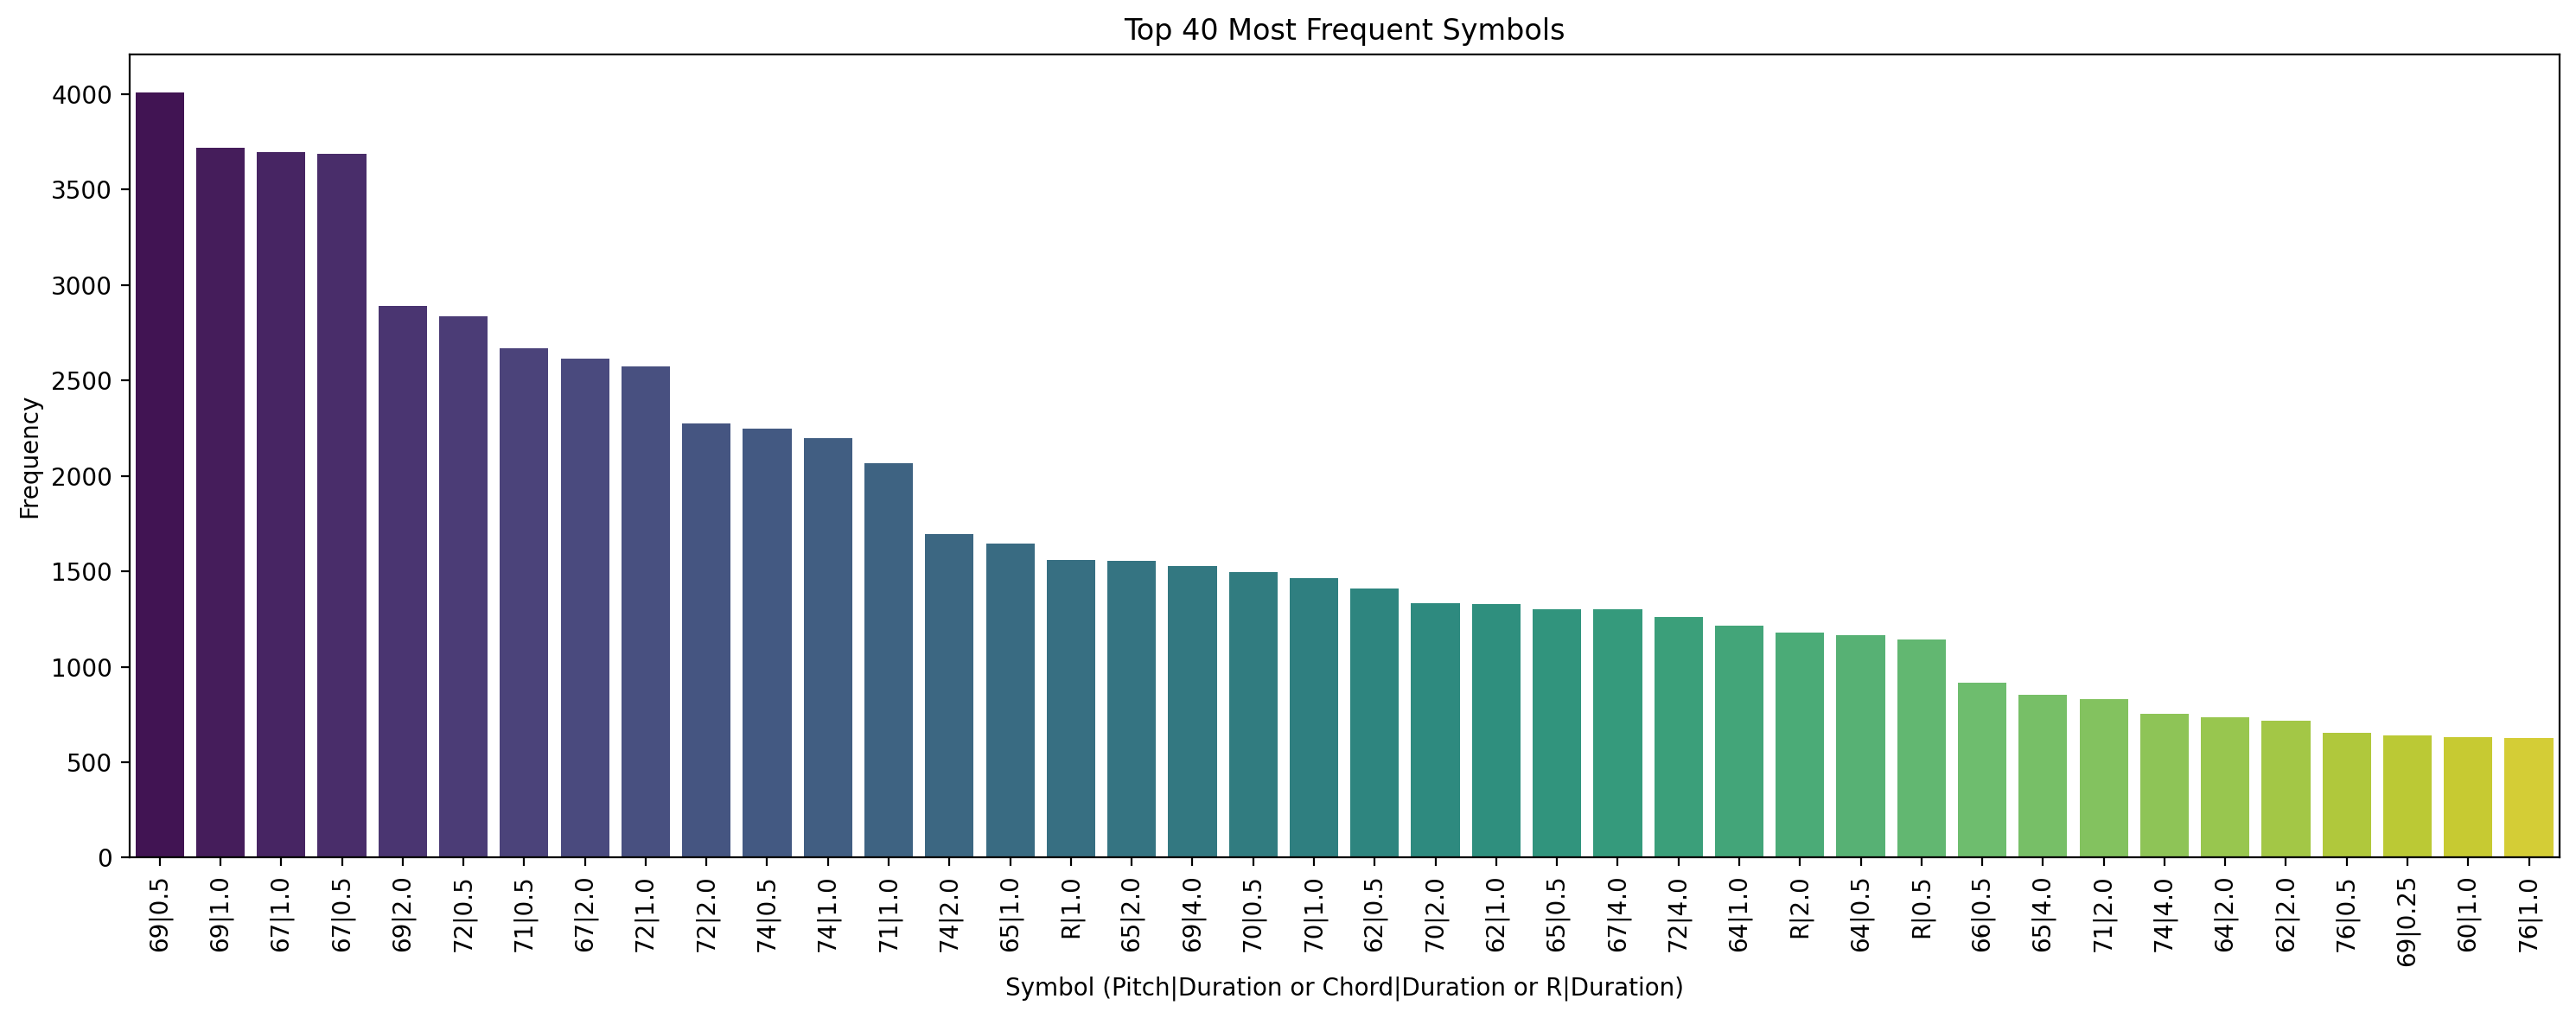

In [27]:
if all_symbols:
    visualize_symbol_distribution(all_symbols, top_n=40)

In [28]:
visualize_audio_file(TEST_FILE_1, title=f"Sample: {os.path.basename(TEST_FILE_1)}")
visualize_audio_file(TEST_FILE_2, title=f"Sample: {os.path.basename(TEST_FILE_2)}")

#### Prepare Sequences for LSTM

Convert the flat list of symbols into input sequences (X) and target outputs (y).

In [29]:
X, y = None, None
if all_symbols and vocab_size > 0:
    try:
        X, y, actual_vocab_size = prepare_sequences(all_symbols, symbol_to_int, SEQUENCE_LENGTH, STEP)
        if X is None or y is None:
            print("\nCRITICAL ERROR: Failed to prepare sequences. Cannot continue.")
            exit()
        if actual_vocab_size != vocab_size:
             print(f"Warning: Vocabulary size mismatch! Mapping: {vocab_size}, Sequences: {actual_vocab_size}")
             vocab_size = actual_vocab_size
    except Exception as e:
        print(f"\nCRITICAL ERROR during sequence preparation: {e}")
        exit()
else:
     print("Skipping sequence preparation as symbols or vocabulary are missing.")
     exit()


Total sequences generated: 90210
One-hot encoding sequences... This might take time and memory.
One-hot encoding finished.
Shape of input sequences (one-hot): (90210, 64, 368)
Shape of target outputs (categorical): (90210, 368)


#### Build the Model

Define the LSTM model architecture.

In [30]:
model = None
if X is not None and y is not None and vocab_size > 0:
    model_input_shape = (X.shape[1], X.shape[2])
    model = build_model(model_input_shape, vocab_size)
else:
    print("Skipping model building due to missing data.")
    exit()

d:\Orphia\orphia-env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64, 256)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 368)            │        94,576 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,888 (4.81 MB)

 Trainable params: 1,259,888 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the Model

Train the model using the prepared data (X, y).


Starting model training...
Epochs: 200, Batch Size: 128, Validation Split: 0.15
Checkpoints will be saved to directory: results
TensorBoard logs available in: results\logs
Epoch 1/200
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.0445 - loss: 4.4807
Epoch 1: val_loss improved from inf to 4.33206, saving model to results\model-weights-01-4.3321.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 256s 423ms/step - accuracy: 0.0446 - loss: 4.4803 - val_accuracy: 0.0729 - val_loss: 4.3321
Epoch 2/200
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.0845 - loss: 3.8209
Epoch 2: val_loss improved from 4.33206 to 3.88374, saving model to results\model-weights-02-3.8837.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 259s 432ms/step - accuracy: 0.0845 - loss: 3.8208 - val_accuracy: 0.0965 - val_loss: 3.8837
Epoch 3/200
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.1264 - loss: 3.4051
Epoch 3: val_loss improved from 3.88374 to 3.57831, saving model to results\model-weights-03-3.5783.keras
600/

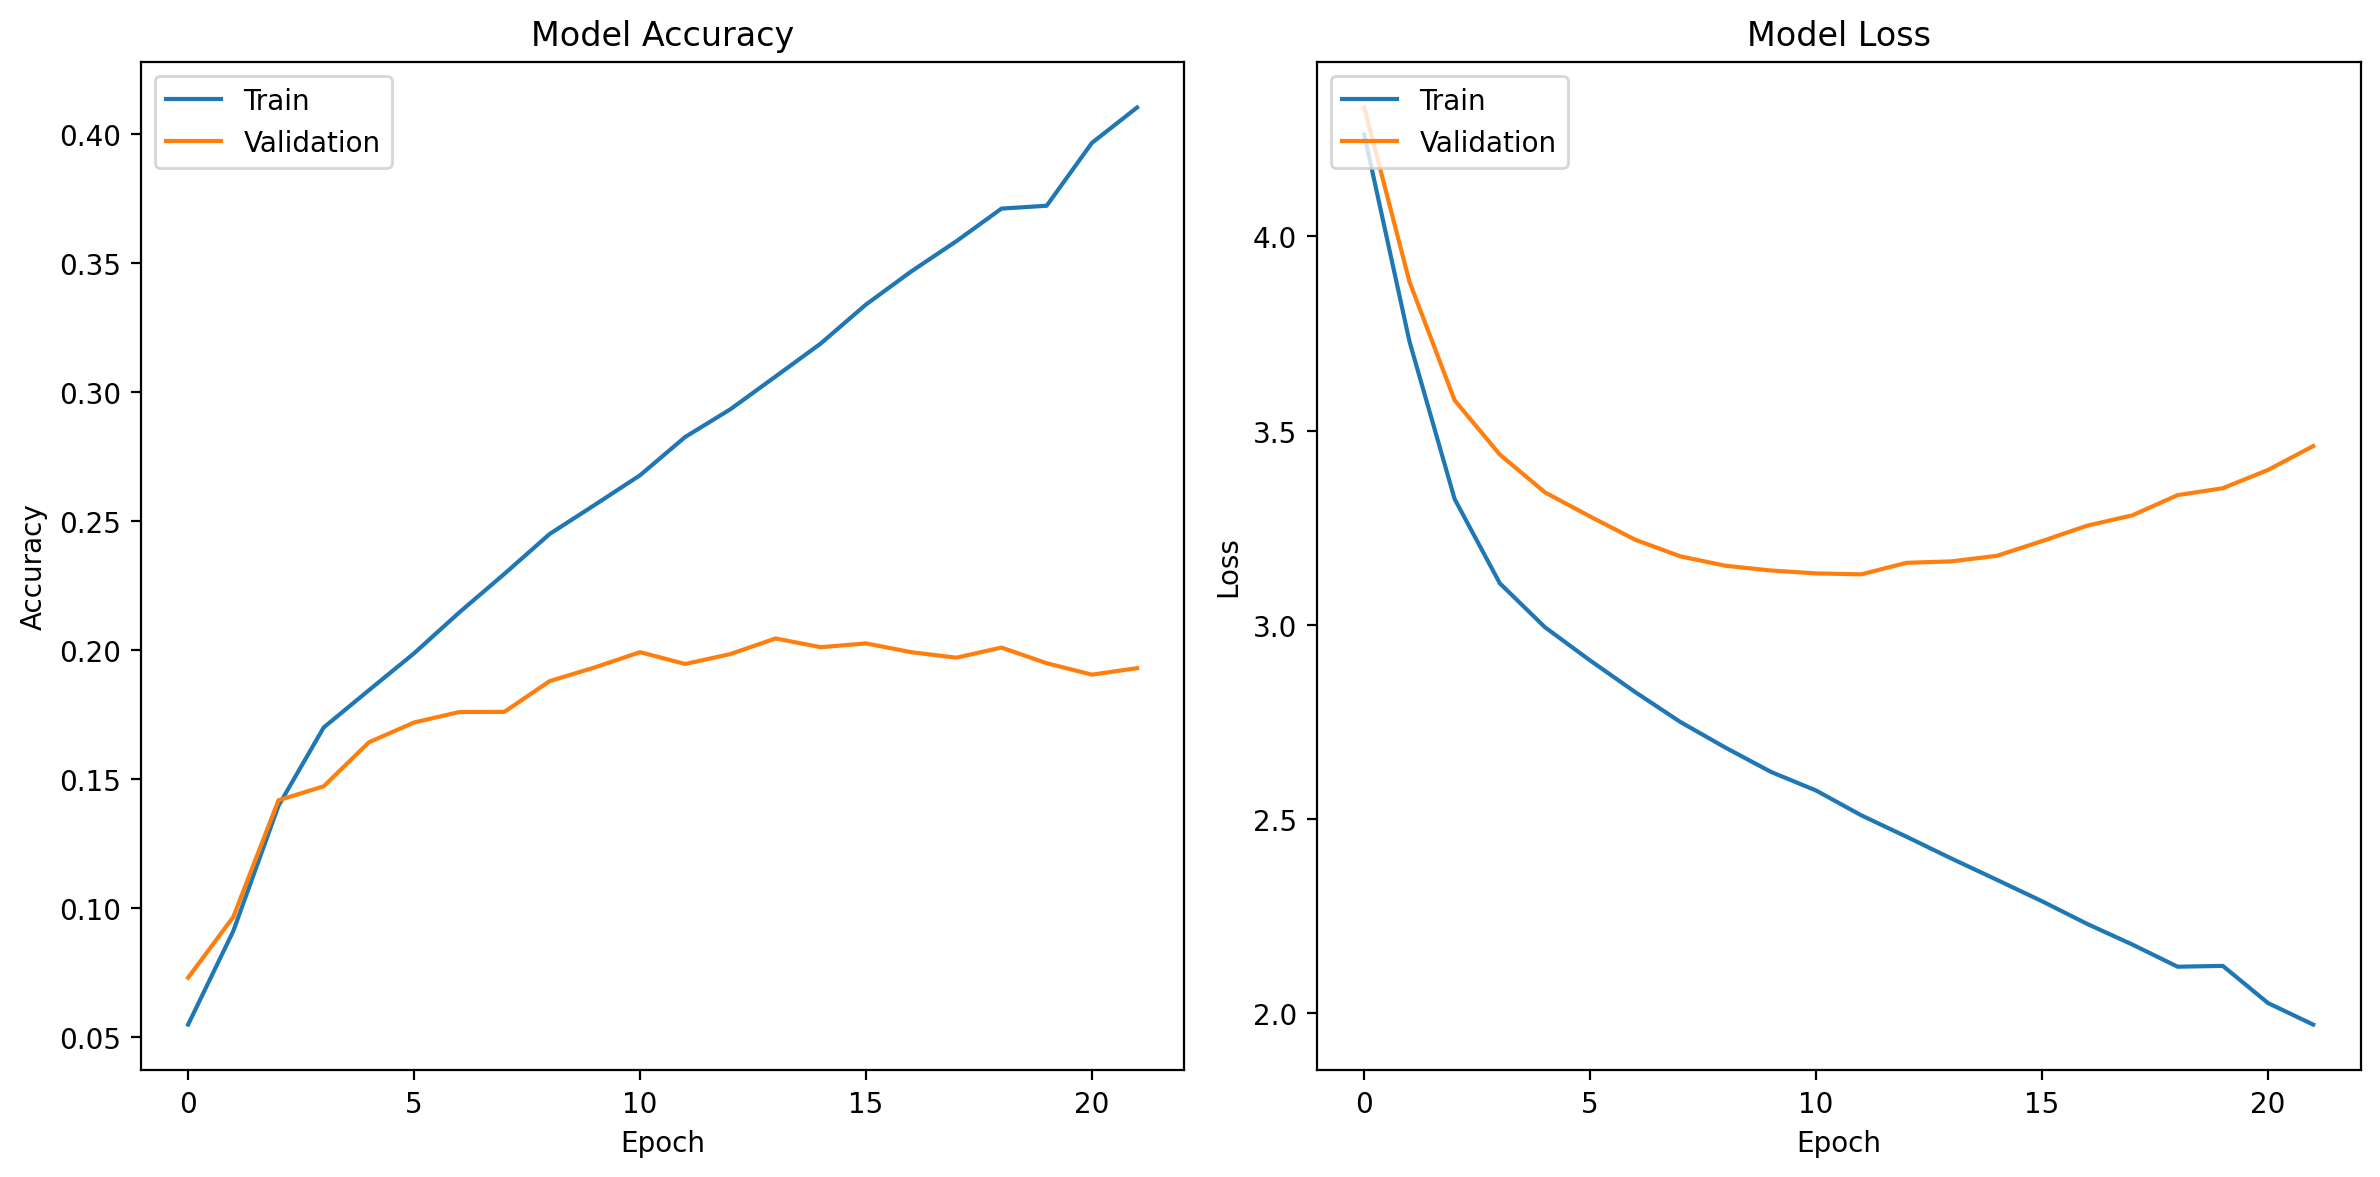

In [31]:
history = None
if model is not None:
    try:
        history = train_model(
            model, X, y,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            val_split=VALIDATION_SPLIT,
            checkpoint_path=MODEL_CHECKPOINT_PATH,
            earlystopping_patience=10,
            tensorboard_log_dir=LOG_DIR
        )
    except Exception as e:
        print(f"\nERROR during model training: {e}")

    if model is not None and history is not None:
        try:
            model.save(FINAL_MODEL_PATH)
            print(f"\nTraining finished or stopped. Final model state saved to {FINAL_MODEL_PATH}")
            plot_training_history(history)
        except Exception as e:
            print(f"ERROR saving final model: {e}")
    elif model is not None:
         print("Skipping saving final model as training did not complete successfully or was interrupted.")
else:
    print("Skipping training as model was not built.")

#### Generate Melody

Use the trained model to generate a new sequence of musical symbols.

In [32]:
generated_music_symbols = None
try:
    if not os.path.exists(MAPPING_PATH):
        raise FileNotFoundError(f"Mapping file not found at {MAPPING_PATH}. Cannot generate.")
    with open(MAPPING_PATH, "r") as fp:
        symbol_to_int_loaded = json.load(fp)
    int_to_symbol_loaded = {i: s for s, i in symbol_to_int_loaded.items()}
    loaded_vocab_size = len(symbol_to_int_loaded)
    print(f"Loaded mappings with vocab size: {loaded_vocab_size}")

    model_to_load_path = None
    best_checkpoint_path = None
    checkpoint_dir = os.path.dirname(MODEL_CHECKPOINT_PATH)
    try:
        if os.path.exists(checkpoint_dir):
            checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith("model-weights") and f.endswith(".keras")]
            if checkpoint_files:

                best_checkpoint_file = sorted(checkpoint_files, key=lambda x: float(x.split('-')[-1].replace('.keras','')))[0]
                candidate_path = os.path.join(checkpoint_dir, best_checkpoint_file)
                if os.path.exists(candidate_path):
                    best_checkpoint_path = candidate_path
                    print(f"Found best checkpoint: {best_checkpoint_file}")
    except Exception as e:
         print(f"Could not parse checkpoint files to find best model. Error: {e}")

    if best_checkpoint_path:
        model_to_load_path = best_checkpoint_path
    elif os.path.exists(FINAL_MODEL_PATH):
        model_to_load_path = FINAL_MODEL_PATH
        print("Using final model saved after training.")
    else:
        raise FileNotFoundError(f"No suitable model file found (.keras format). Looked for checkpoints in '{checkpoint_dir}' and final model at '{FINAL_MODEL_PATH}'. Ensure training completed and saved a model.")

    print(f"Loading model from: {model_to_load_path}")
    loaded_model = keras.models.load_model(model_to_load_path)
    print("Model loaded successfully.")

    if 'X' in locals() and X is not None:
        seed_index = np.random.randint(0, len(X))
        seed_sequence_onehot = X[seed_index]
        seed_sequence_int = np.argmax(seed_sequence_onehot, axis=1)
        print(f"Using random seed sequence index: {seed_index}, length: {len(seed_sequence_int)}")
    else:
        print("Warning: X data not available in memory. Creating a random integer seed sequence.")
        if loaded_vocab_size < SEQUENCE_LENGTH:
             raise ValueError(f"Cannot create seed: Vocabulary size ({loaded_vocab_size}) is smaller than sequence length ({SEQUENCE_LENGTH}).")
        start_index = np.random.randint(0, loaded_vocab_size - SEQUENCE_LENGTH)
        seed_sequence_int = list(range(start_index, start_index + SEQUENCE_LENGTH))
        print(f"Using random integer seed (indices {start_index} to {start_index + SEQUENCE_LENGTH - 1})")

    generated_music_symbols = generate_melody(
        loaded_model,
        seed_sequence_int,
        int_to_symbol_loaded,
        loaded_vocab_size,
        MELODY_DURATION_SYMBOLS,
        TEMPERATURE
    )

except FileNotFoundError as e:
    print(f"\nError loading resources for generation: {e}")
    print("Cannot proceed with generation.")
except Exception as e:
    print(f"\nAn unexpected error occurred during generation setup or execution: {e}")

Loaded mappings with vocab size: 368
Found best checkpoint: model-weights-12-3.1303.keras
Loading model from: results\model-weights-12-3.1303.keras
Model loaded successfully.
Using random seed sequence index: 29208, length: 64

Generating melody...
Seed length: 64, Symbols to generate: 200, Temperature: 1.0
Generated 200/200 symbols...
Generation complete.


#### Convert Generated Symbols to MIDI, Synthesize WAV, and Visualize

Process the output from the generation step.


Converting 264 symbols to MIDI...
MIDI file saved successfully to: results\generated_melody.mid

Attempting to display generated score (requires music21 setup)...


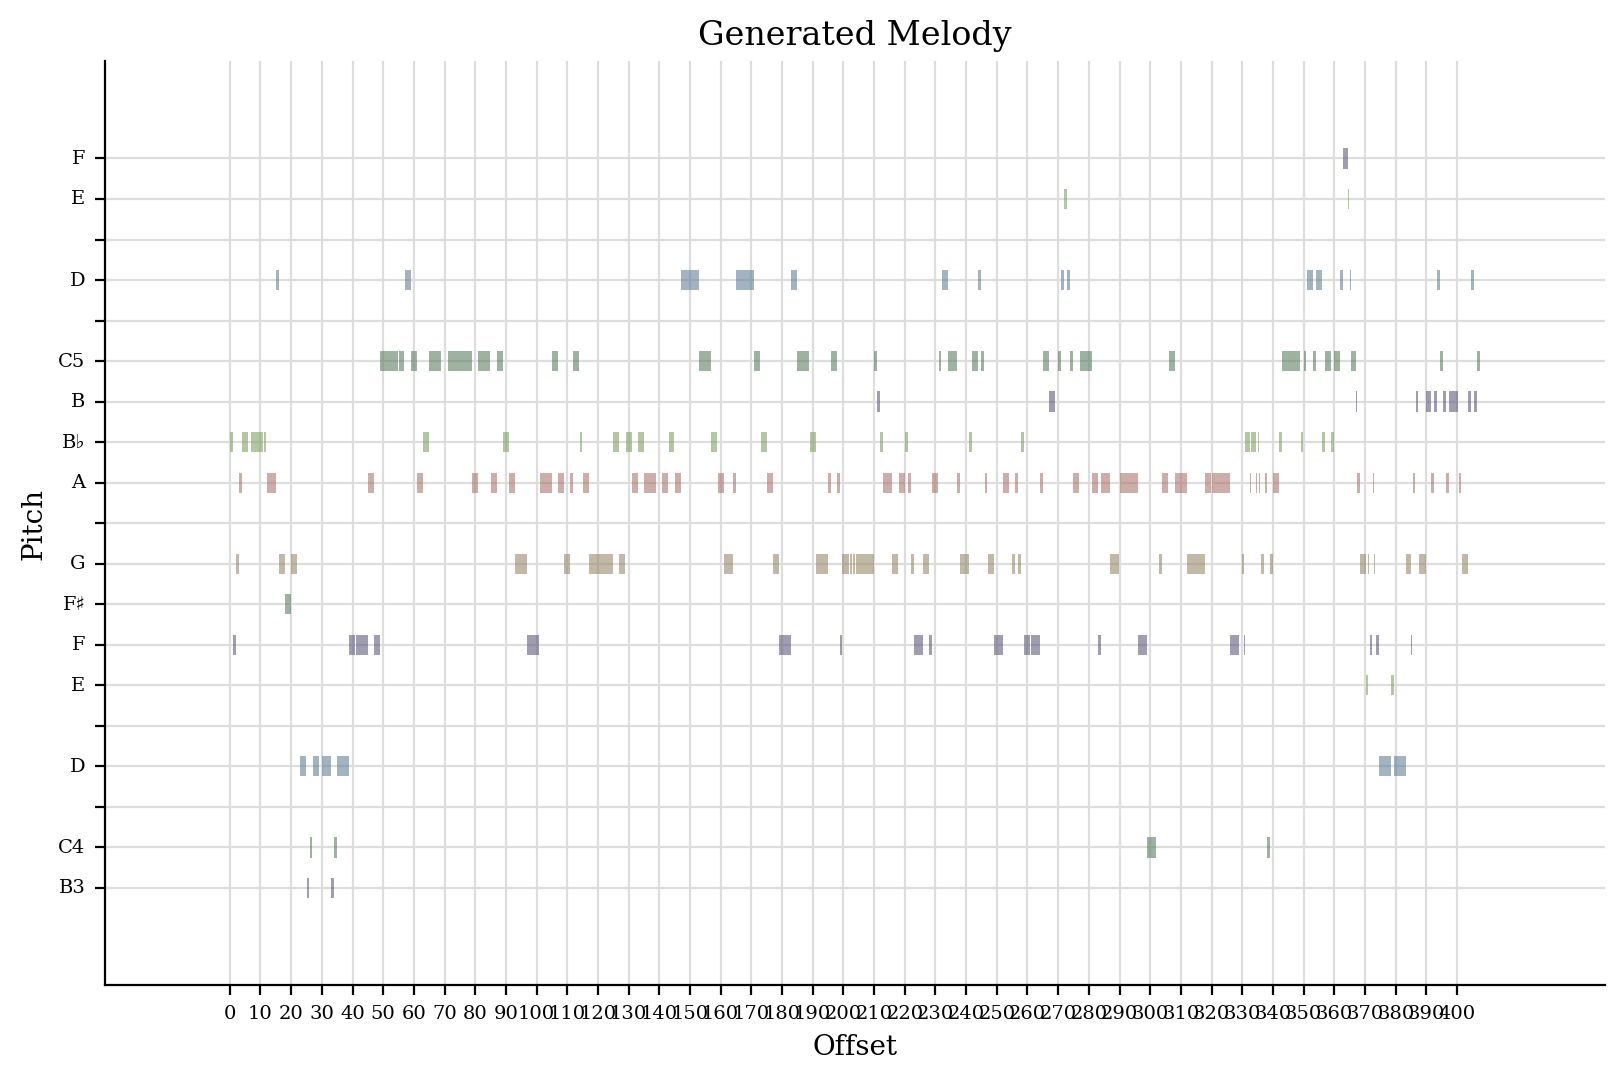

In [33]:
if generated_music_symbols:
    try:
        _ = convert_symbols_to_midi(generated_music_symbols, GENERATED_MIDI_PATH)
    except Exception as e:
        print(f"Error during MIDI conversion or visualization: {e}")
else:
    print("\nSkipping MIDI conversion as no symbols were generated.")